In [1]:
import os
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.coordinates import SkyCoord
# from astropy.time import Time
from astropy.visualization import ImageNormalize, SqrtStretch
import sunpy.coordinates  # NOQA
import sunpy.map
from sunpy.net import Fido
from sunpy.net import attrs as a
import eispac
import eispac.net
from eispac.net.attrs import FileType
import glob
import numpy as np
import pdb
from aiapy.psf import deconvolve, psf
from astropy.visualization import ImageNormalize, LogStretch, time_support
from tqdm import tqdm
import astropy.io.ascii as ascii
import pdb
from museval.io import create_session, is_complete, extract_remote_str, files_to_retry


In [2]:
### depending on setup, this routine may not be needed
######################################################
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
from parfive import SessionConfig
from parfive import Downloader
dl = Downloader(config=SessionConfig(aiohttp_session_generator=create_session))
######################################################

In [6]:
test_path = '/Users/souvikb/MUSE_outputs/EIS_IRIS_QS_obs/Plage_datasets/HOP_307/SDO_EIS_cutouts_2017-06-07T04:41:20/'

In [7]:
aia_171_fdisk = sunpy.map.Map(test_path+'aia.lev1_euv_12s.2017-06-07T044222Z.171.image_lev1.fits')
aia_193_fdisk = sunpy.map.Map(test_path+'aia.lev1_euv_12s.2017-06-07T044218Z.193.image_lev1.fits')

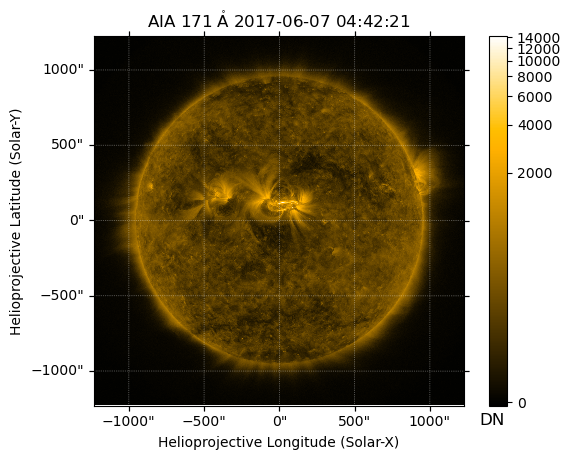

In [26]:
aia_171_fdisk.peek()

In [15]:
## Reading the PSFs for AIA deconvolution
PSF_aia_team = np.load('/Users/souvikb/MUSE_outputs/EIS_IRIS_QS_obs/AIA_PSFs/aia_psfs_added.npz',allow_pickle=True)
PSF_aia_team['psf171'].shape

(4096, 4096)

In [16]:
aia_171_dconv = deconvolve(aia_171_fdisk, psf = PSF_aia_team['psf171'])
aia_193_dconv = deconvolve(aia_193_fdisk, psf = PSF_aia_team['psf193'])

2025-10-07 15:24:23 - sunpy - INFO: cupy not installed or working, falling back to CPU


INFO: cupy not installed or working, falling back to CPU [aiapy.psf.deconvolve]


2025-10-07 15:24:33 - sunpy - INFO: cupy not installed or working, falling back to CPU


INFO: cupy not installed or working, falling back to CPU [aiapy.psf.deconvolve]


In [ ]:
bottom_left = SkyCoord(data.meta['extent_arcsec'][0]*u.arcsec, data.meta['extent_arcsec'][2]*u.arcsec, obstime=data.meta['mod_index']['date_obs'], observer="earth", frame="helioprojective")
top_right = SkyCoord(data.meta['extent_arcsec'][1]*u.arcsec, data.meta['extent_arcsec'][3]*u.arcsec, obstime=data.meta['mod_index']['date_obs'], observer="earth", frame="helioprojective")
cutout = a.jsoc.Cutout(bottom_left, top_right=top_right, tracking=True)

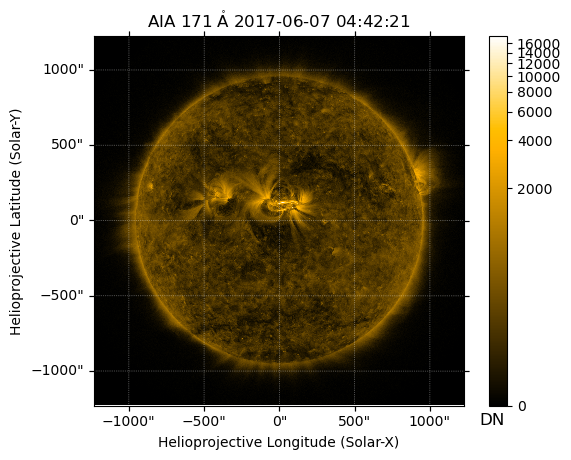

In [25]:
aia_171_dconv.peek()

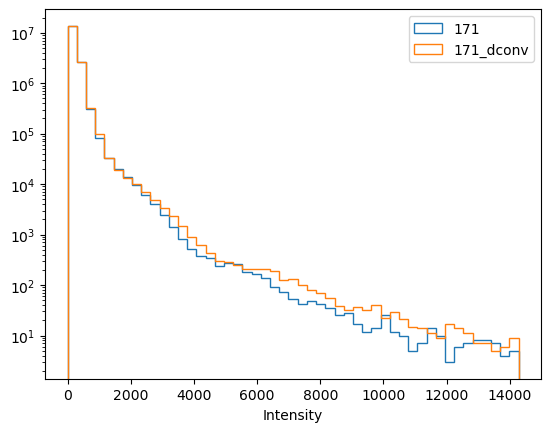

In [22]:
## Histograms for comparing the intensities
num_bins = 50
bins = np.linspace(aia_171_fdisk.min(), aia_171_fdisk.max(), num_bins)
hist_171_fdisk, bin_edges = np.histogram(aia_171_fdisk.data, bins=bins)
hist_171_dconv, bin_edges = np.histogram(aia_171_dconv.data, bins=bins)

fig,ax =plt.subplots()
ax.hist(aia_171_fdisk.data.ravel(), bins=bins, label='171', histtype='step')
ax.hist(aia_171_dconv.data.ravel(), bins=bins, label='171_dconv', histtype='step')
ax.set_xlabel('Intensity')
ax.set_yscale('log')
plt.legend()

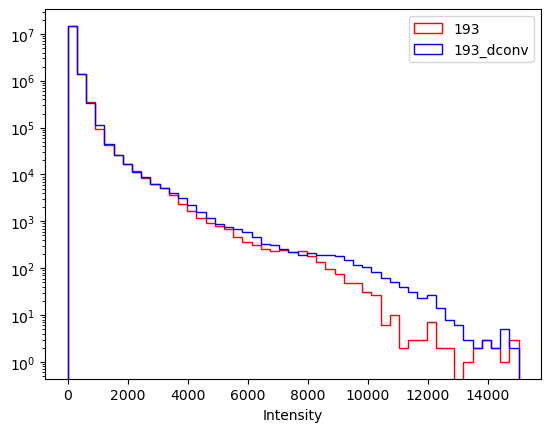

In [24]:
## Histograms for comparing the intensities
num_bins = 50
bins = np.linspace(aia_193_fdisk.min(), aia_193_fdisk.max(), num_bins)
hist_193_fdisk, bin_edges = np.histogram(aia_193_fdisk.data, bins=bins)
hist_193_dconv, bin_edges = np.histogram(aia_193_dconv.data, bins=bins)

fig,ax =plt.subplots()
ax.hist(aia_193_fdisk.data.ravel(), bins=bins, label='193', histtype='step',color='red')
ax.hist(aia_193_dconv.data.ravel(), bins=bins, label='193_dconv', histtype='step',color='blue')
ax.set_xlabel('Intensity')
ax.set_yscale('log')
plt.legend()

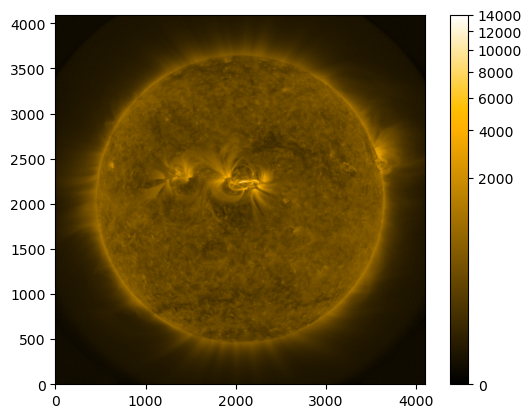

In [33]:
## IDL deconvolved AIA 171
from astropy.io import fits
from matplotlib import colors
# IDL_deconv_171_fdisk = sunpy.map.Map(test_path+'aia_171_fdisk_dconv_IDL.fits')
IDL_deconv_171_fdisk = fits.getdata(test_path+'aia_171_fdisk_dconv_IDL.fits')
plt.imshow(IDL_deconv_171_fdisk, origin='lower',cmap='sdoaia171', norm=colors.PowerNorm(0.3,vmin=0,vmax=1.4e4))
plt.colorbar()

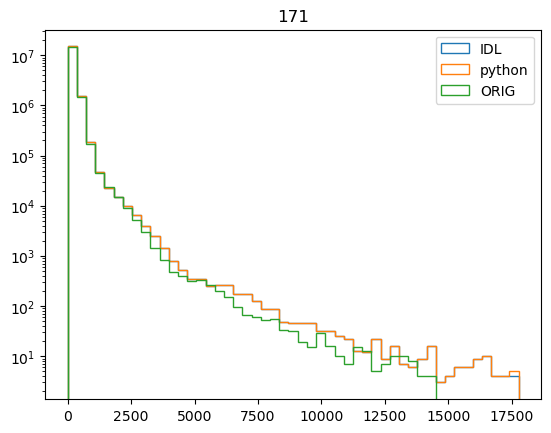

In [ ]:
## Histograms for comparing the intensities
num_bins=50
bins = np.linspace(aia_171_dconv.data.min(), aia_171_dconv.data.max(), num_bins)
plt.hist(IDL_deconv_171_fdisk.ravel(), bins=bins, histtype='step', label='IDL')
plt.hist(aia_171_dconv.data.ravel(), bins=bins, histtype='step', label='python')
plt.hist(aia_171_fdisk.data.ravel(), bins=bins, histtype='step', label='ORIG')
plt.yscale('log')
plt.title('171')
plt.legend()